In [13]:
import itertools
import os
from collections import namedtuple
from math import exp

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.helpers import (AllAsymptotics,
load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe,
AllDeltas)
from empirical_privacy import laplace_mechanism, config
from experiment_framework.asymptotic_analysis import compute_bootstrapped_upper_bound

from notebook_context import *

In [14]:
epsilons = [
    0.01,
    0.1,
    1.,
]
dses = [{
        'database_0' : (0, 0, 0),
        'database_1' : (1, 0, 0),
        'sensitivity': 1.,
        'epsilon'    : eps,
        'delta'      : 0.
} for eps in epsilons]

asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack'
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 30,
    'n_trials_per_training_set_size': 30,
    'n_max'              : 2**14,
    'validation_set_size': 2**12,
    'p'                  : 0.9,  # for bootstrap
    't'                  : 0.001  # for bootstrap
}

In [15]:
CCCs = dict()
Alls = dict()
AAs = dict()
CLBDs = dict()

for (i, ds) in enumerate(dses):
    eps = epsilons[i]
    All = AllDeltas(
            gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
            dataset_settings=ds,
            asymptotic_settings=asys,
            claimed_epsilon=0.5*eps
    )
    Alls[eps] = All
    CLBDs[eps] = All.requires()
    AAs[eps] = [CLBD.requires()['asymptotic_accuracy'] for CLBD in CLBDs[eps]]
    CCCs[eps] = [AA.requires()['CCC'] for AA in AAs[eps]]
    

##### To build this requires the scheduler server running
1. Open a terminal in the docker container.
  * Click on the Jupyter logo in the top-left, then click New>Terminal.
2. Run the scheduler.
  * `luigid`
3. Execute the build in the cell below, and observe progress in the scheduler's UI at port 8082.

In [16]:
CCC_jobs = list(itertools.chain(*[[CLBD.requires()['asymptotic_accuracy'].requires()['CCC'] for CLBD in All.requires()] for All in Alls.values()]))
luigi.build(CCC_jobs, workers=15, log_level='ERROR')  # compute CCCs using 16 workers since they're single threaded
luigi.build([All for All in Alls.values()], workers=2, log_level='ERROR')  # do bootstrap using 2 workers since each bootstrap is parallelized

True

### Plot outcomes for all trials

In [17]:
import pandas as pd

from scipy.optimize import least_squares

from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p_two_sided, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

### With correct delta:

In [18]:
for eps in epsilons:
    n_succ = 0
    n_tot = 0
    print(eps)
    for clbd in CLBDs[eps]:
        
        with clbd.output().open() as f:
            delta = dill.load(f)
#             print(f'\t{delta}')
            n_tot+=1
            n_succ += delta['lower_bound'] <= 0 and delta['upper_bound'] >= 0
    print(f'eps={eps} n_succ={n_succ} n_tot={n_tot}')

0.01
eps=0.01 n_succ=30 n_tot=30
0.1
eps=0.1 n_succ=30 n_tot=30
1.0
eps=1.0 n_succ=0 n_tot=30


### claimed epsilon too low

In [19]:
for eps in epsilons:
    n_succ = 0
    n_tot = 0
    print(eps)
    for clbd in CLBDs[eps]:
        
        with clbd.output().open() as f:
            delta = dill.load(f)
            print(f'\tdelta={delta} mean={(delta["upper_bound"]+delta["lower_bound"])/2}')
            n_tot+=1
            n_succ += delta['lower_bound'] > 0
    print(f'eps={eps} n_succ={n_succ} n_tot={n_tot}')

0.01
	delta={'lower_bound': -0.0059934033254985799, 'upper_bound': 0.010287009944130159} mean=0.0021468033093157896
	delta={'lower_bound': -0.003542684177865536, 'upper_bound': 0.015453669418028634} mean=0.005955492620081549
	delta={'lower_bound': -0.0082193006842073511, 'upper_bound': 0.013156503380284864} mean=0.0024686013480387566
	delta={'lower_bound': -0.0058313976850566818, 'upper_bound': 0.012980922024939343} mean=0.0035747621699413305
	delta={'lower_bound': -0.007673270915510763, 'upper_bound': 0.017047047900757114} mean=0.004686888492623175
	delta={'lower_bound': -0.0072606117277344657, 'upper_bound': 0.010038406372279204} mean=0.001388897322272369
	delta={'lower_bound': -0.0057101423115469346, 'upper_bound': 0.016777968714147991} mean=0.005533913201300528
	delta={'lower_bound': -0.004277909810719331, 'upper_bound': 0.016404967486524383} mean=0.0060635288379025255
	delta={'lower_bound': -0.0040675986477731567, 'upper_bound': 0.01555300876932755} mean=0.0057427050607771965
	del

In [32]:
eps = 0.2
ds = dses[epsilons.index(eps)]
delta = ds['delta']

All = AllAsymptotics(
            gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
            dataset_settings=ds,
            asymptotic_settings=asys)
CCCs = [AA.requires()['CCC'] for AA in All.requires()]

AAs = All.requires()
DF = load_completed_AAs_into_dataframe(AAs)


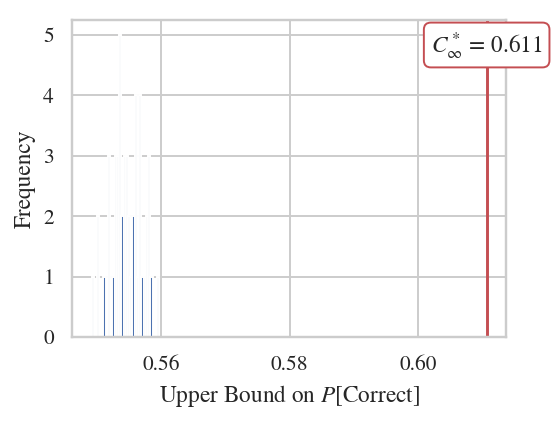

In [33]:
ax = DF.upper_bound.plot(kind='hist', bins=30)
true_ub = pc(eps, delta)
plt.axvline(x=true_ub, color='r')
plt.text(x=true_ub,
         y=0.9,
         s='$C_\infty^*$ = {:.3f}'.format(true_ub),
         transform=x_data_y_axis(),
         horizontalalignment='center',
         bbox=dict(facecolor='w', edgecolor='r', boxstyle='round')
        )
plt.xlabel('Upper Bound on $P[$Correct$]$')


if SAVE_FIGURES_FOR_LATEX:
    plt.title('')
    plt.ylabel('Frequency')
    plt.xlabel('Estimated Upper Bound on $C^*_\infty$')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, 'experiment_4_upper_bound_histogram.eps'))

In [34]:
configure_plotting_for_publication()

SAVE_FIGURES_FOR_LATEX = False


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

(10500, 10)
Training set sizes =  256 -- 16384


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


m=0.5316425540852373 C=0.0618504569081994


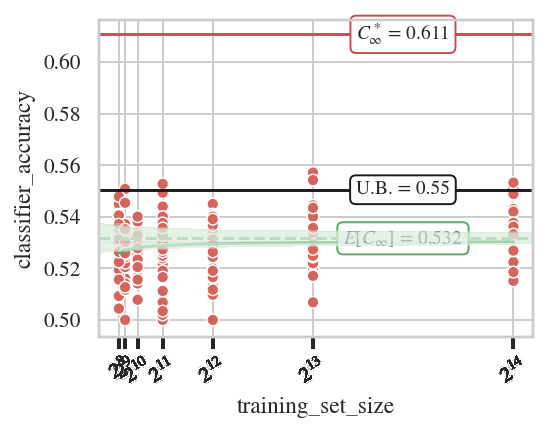

In [35]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)
print(DFccc.shape)

confidence_interval_width = 0.01
confidence_interval_prob = 0.9
    
def plot_CCC_DF(DF, doc_ind=None, d=3):
    global SAVE_FIGURES_FOR_LATEX
    print('Training set sizes = ',
          DF.training_set_size.min(),
          '--',
          DF.training_set_size.max()
         )
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue='doc_ind',
        legend=None,
        palette=cp,
    
    )
   
    # curve for all the data
    d=3
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    m, C = asymptotic_curve(ks, y)
    print(f'm={m} C={C}')
    
    # bootstrap for ub
    boot_res = compute_bootstrapped_upper_bound(x, d, fit_model, y,
                                 confidence_interval_prob,
                                 confidence_interval_width)
    samples = boot_res['bootstrap_samples'] 
    
    ub = boot_res['ub']
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base),
                     np.log(np.max(x))/np.log(base),
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    labeled_axhline(ub, 'U.B.', 'k', handle)
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--')
    labeled_axhline(pc(eps, delta), '$C_\infty^*$', 'r', handle)
    
    plt.xticks(x, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in x],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.75},
                 rug=False,
                 vertical=True,
                 color='g',
                ax=ax2)

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_4_bootstrap_visualization.png'))


    
# call the function
plot_CCC_DF(DFccc, 1)
